In [2]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [3]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 0.2  # in s
signal_power = 0.0  # in dB
noise_power = 15.0  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.soft(f_center=-1e5, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=None)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: -0.00 dB
Noise power:  14.98 dB
SNR:          -14.98 dB
Num samples:  200000 


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


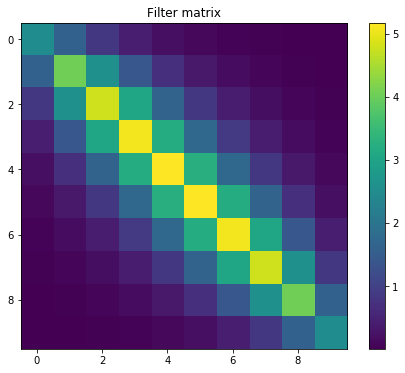

In [9]:
n = 10
cov_size = 10

w_mats = np.empty((0, cov_size, cov_size))
for i in tqdm.tqdm(range(n)):
    noi = wgn.signal(power=0, dB=True)
    noi_fil = ss.filter.fir_bandpass(noi,
                                     f_min=-4e5,
                                     f_max=-2e5,
                                     f_sample=sample_freq,
                                     n_taps=5)
    w_mat = ss.eigen_detector.whitening_mat(noi_fil, l=cov_size)
    w_mat = np.reshape(w_mat, (1, cov_size, cov_size))
    w_mats = np.append(w_mats, w_mat, axis=0)

w_mat = np.mean(w_mats, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(np.abs(w_mat))
plt.colorbar()
plt.title('Filter matrix')
plt.show()

In [10]:
# apply bandpass filter to noise
noise = wgn.signal(power=noise_power, dB=True)
noi_fil = ss.filter.fir_bandpass(noi,
                                 f_min=-4e5,
                                 f_max=-2e5,
                                 f_sample=sample_freq,
                                 n_taps=5)

# check what the stats have to say
pfa = 0.1
thr = ss.eigen_stats.mme_thr(Ns=num_samples, L=cov_size, Pfa=pfa)
eng_noise = ss.eigen_detector.mme(x=noise, l=cov_size)
eng_noise_fil = ss.eigen_detector.mme(x=noi_fil, l=cov_size, w_mat=w_mat)

print('Prob false alarm:   %.4f' % (pfa))
print('Threshold:          %.4f' % (thr))
print('Noise only mme:     %.4f' % (eng_noise))
print('Filtered noise mme: %.4f' % (eng_noise_fil))

Prob false alarm:   0.1000
Threshold:          1.0294
Noise only mme:     1.0234
Filtered noise mme: 1.0235


In [23]:
diffs = []
for i in tqdm.tqdm(range(n)):
    noi = wgn.signal(power=noise_power, dB=True)
    noi_fil = ss.filter.fir_bandpass(noi,
                                     f_min=-4e5,
                                     f_max=-2e5,
                                     f_sample=sample_freq)
    eng_noi = ss.eigen_detector.mme(x=noi, l=cov_size)
    eng_noi_fil = ss.eigen_detector.mme(x=noi_fil, l=cov_size, w_mat=w_mat)
    diff = eng_noi_fil - eng_noi
    #     print(diff)
    diffs.append(diff)

diff_mean = np.mean(diffs, axis=0)
print('Mean difference', diff_mean)

100%|██████████| 10/10 [00:32<00:00,  3.21s/it]

Mean difference 0.027330572841844238


In [24]:
# apply bandpass filter to noise
noise = wgn.signal(power=noise_power, dB=True)
noi_fil = ss.filter.fir_bandpass(noi,
                                 f_min=-4e5,
                                 f_max=-2e5,
                                 f_sample=sample_freq)

# check what the stats have to say
pfa = 0.1
thr = ss.eigen_stats.mme_thr(Ns=num_samples, L=cov_size, Pfa=pfa)
eng_noise = ss.eigen_detector.mme(x=noise, l=cov_size)
eng_noise_fil = ss.eigen_detector.mme(x=noi_fil, l=cov_size, w_mat=w_mat)

print('Prob false alarm:   %.4f' % (pfa))
print('Threshold:          %.4f' % (thr))
print('Noise only mme:     %.4f' % (eng_noise))
print('Filtered noise mme: %.4f' % (eng_noise_fil - diff_mean))

Prob false alarm:   0.1000
Threshold:          1.0294
Noise only mme:     1.0296
Filtered noise mme: 1.0284
